In [1]:
#library imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from json import JSONDecoder, JSONDecodeError
import statistics
import re
import jenkspy

In [2]:
#importing data
month_velib = open('./raw_sets/velib/data_all_Paris.jjson_2017-09-01-1504239946.jjson', 'r').read()

NOT_WHITESPACE = re.compile(r'[^\s]')

def decode_stacked(document, pos=0, decoder=JSONDecoder()):
    while True:
        match = NOT_WHITESPACE.search(document, pos)
        if not match:
            return
        pos = match.start()

        try:
            obj, pos = decoder.raw_decode(document, pos)
        except JSONDecodeError:
            # do something sensible if there's some error
            raise
        yield obj



In [3]:
#decode each json observation in month
df = []
for obj in decode_stacked(month_velib):
    df.append(pd.DataFrame(obj))
# sample
# obs = pd.DataFrame(next(decode_stacked(month_velib)))


In [4]:
"""
Restructuring the data so that all of the unique observations are organized per station
"""

stations = {}
for observation in df:
    for row in observation.iterrows():
        station = row[1]
        number = str(station['number'])
        last_update = str(station['last_update'])
        if number not in stations:
            stations[number] = {}
        #make sure it's not a duplicate observation
        if last_update not in stations[number]:
            stations[number][last_update] = {
                'available_bikes' : station['available_bikes'],
                'available_bike_stands' : station['available_bike_stands'],
                'bike_stands' : station['bike_stands']
            }

In [6]:
"""
Now that the data is organized by station, find the std deviation of bikes available

concerns:
- underestimating singletons where the same amount of bikes docked
"""

station_keys = list(stations.keys())
ambig = []
for station_key in station_keys:
    station = stations[station_key]
    station['availability'] = []
    station['availability_scaled'] = []
    for timestamp in station.keys():
        timestamp = str(timestamp)
        if type(station[timestamp]) == dict:
            bikes = station[timestamp]['available_bikes']
            bikes_scaled = station[timestamp]['available_bikes'] / station[timestamp]['bike_stands']
            station['availability'].append(bikes)
            station['availability_scaled'].append(bikes_scaled)
        else:
            ambig.append(timestamp)
    #calc std deviation
    station['stddev'] = statistics.stdev(station['availability'])
    station['stddev_scaled'] = statistics.stdev(station['availability_scaled'])

(array([ 51., 146., 173., 221., 153., 128., 106.,  78.,  51.,  28.,  21.,
         13.,  11.,   8.,   4.]),
 array([ 0.71041137,  2.06605295,  3.42169453,  4.77733611,  6.13297769,
         7.48861927,  8.84426086, 10.19990244, 11.55554402, 12.9111856 ,
        14.26682718, 15.62246876, 16.97811035, 18.33375193, 19.68939351,
        21.04503509]),
 <a list of 15 Patch objects>)

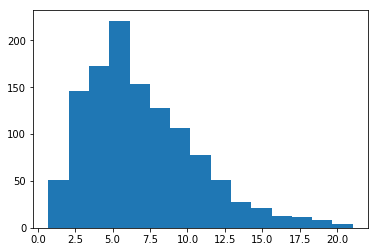

In [7]:
"""
Exploring the distribution of deviations
"""
deviations = []
deviations_scaled = []
for station_key in station_keys:
    station = stations[station_key]
    if station['stddev']:
        deviations_scaled.append(station['stddev_scaled'])
        deviations.append(station['stddev'])

#trimming extreme values
deviations = sorted(deviations)[3:-3]
deviations_scaled = sorted(deviations_scaled)[3:-3]
plt.hist(deviations, 15)

(array([ 13.,  37.,  63.,  78.,  81.,  76.,  94., 112., 125., 126., 141.,
        128.,  73.,  31.,  14.]),
 array([0.02410019, 0.04847682, 0.07285346, 0.09723009, 0.12160672,
        0.14598335, 0.17035998, 0.19473661, 0.21911324, 0.24348988,
        0.26786651, 0.29224314, 0.31661977, 0.3409964 , 0.36537303,
        0.38974966]),
 <a list of 15 Patch objects>)

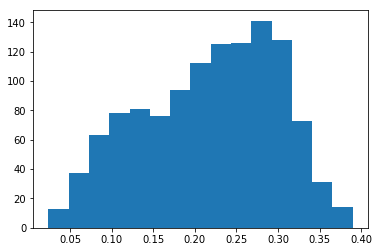

In [8]:
plt.hist(deviations_scaled, 15)

[[314, 428, 450], [240, 283, 328, 341], [184, 203, 298, 314, 193], [129, 184, 211, 240, 276, 152]]


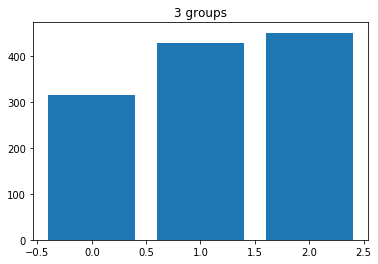

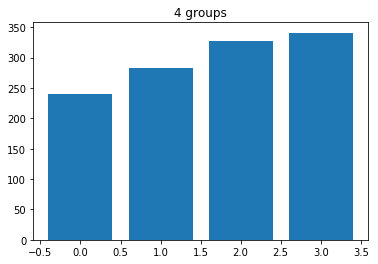

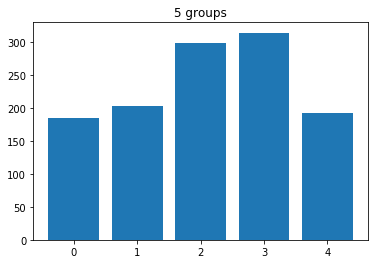

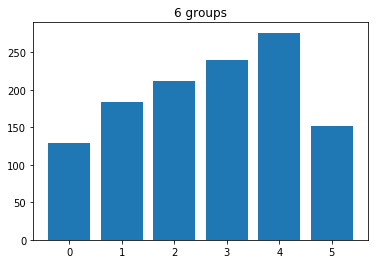

In [44]:
"""
Clustering based on Jenks Normal
"""
classes = []
groups = []

def find_break_idx(n, breaks):
    last = len(breaks) - 1
    for i in range(last):
        if breaks[i] > n and n < breaks[i + 1]:
            return i
    return (last)

for i in range(3, 7):
    classes.append(jenkspy.jenks_breaks(deviations_scaled, nb_class=i))
    groups.append([])

for idx, breaks in enumerate(classes):
    for i in range(len(breaks)):
        groups[idx].append([])
        
for idx, breaks in enumerate(classes):
    for dev in deviations_scaled:
        i = find_break_idx(dev, breaks)
        groups[idx][i].append(dev)

bars = []
for idx, group in enumerate(groups):
    bars.append([])
    for breaks in group:
        bars[idx].append(len(breaks))

for idx, bar in enumerate(bars):
    bars[idx] = bars[idx][1:]

print(bars)
    
for idx, bar in enumerate(bars):
    plt.figure(idx)
    plt.title(str(idx + 3) + ' groups')
    plt.bar(range(len(bar)), bar)
